In [113]:
import pandas as pd
import os
import numpy as np
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format

# LeNet5 Train

In [114]:
os.getcwd()
LENET5 = "runs/LeNet5"

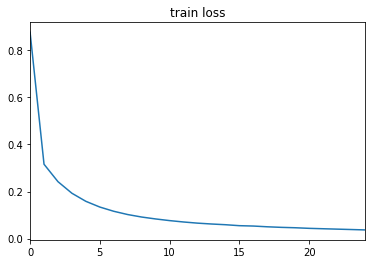

In [115]:
path = os.path.join(LENET5, "train_logs.csv")
df = pd.read_csv(path, index_col=0)
df['train loss'].plot(title='train loss')

# LeNet5 Test
## MNIST

In [116]:
ID_NLL = "runs/LeNet5/mnist_test_nll.csv"
ID_SOFTMAX = "runs/LeNet5/mnist_test_softmax_dist.csv"

# NLL
print("NLL")
df_nll = pd.read_csv(ID_NLL, index_col=0)
print(df_nll.head())
print(df_nll.iloc[:10].std(axis=1))

print("\n\n")

# SOFTMAX
print("SOFTMAX")
df_soft = pd.read_csv(ID_SOFTMAX, index_col=0)
print(df_soft.head())
print(df_soft.iloc[:10].std(axis=1))

NLL
      0     1     2     3     4     5     6     7     8     9
0 14.35 17.02 13.34 10.74 22.09 15.34 32.32  0.00 17.88 11.94
1 12.70  9.57  0.00 12.93 29.44 22.90 17.75 22.81 12.19 27.83
2 11.86  0.00 10.27 13.76  7.84 12.33 10.40  7.33 10.33 13.07
3  0.00 22.09 14.36 16.87 19.85 15.54 11.36 16.84 16.54 11.63
4 14.54 19.56 13.76 17.66  0.00 15.21 13.77 12.35 13.25  7.57
0   8.27
1   9.09
2   4.00
3   6.06
4   5.49
5   5.42
6   6.95
7   4.96
8   7.38
9   8.51
dtype: float64



SOFTMAX
     0    1    2    3    4    5    6    7    8    9
0 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00
1 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
2 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
3 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
4 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00
0   0.32
1   0.32
2   0.32
3   0.32
4   0.32
5   0.32
6   0.31
7   0.32
8   0.31
9   0.32
dtype: float64


Confidence
Min:  0.8290000000000001
Max:  1.0


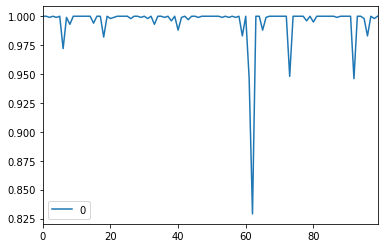

In [117]:
# Confidence
ID_CONFIDENCE = "runs/LeNet5/mnist_test_confidence.csv"
print("Confidence")
df_conf = pd.read_csv(ID_CONFIDENCE, index_col=0)
print("Min: ", df_conf.iloc[:,0].min())
print("Max: ", df_conf.iloc[:,0].max())
df_conf.plot()

Entropy
Min:  0.0
Max:  0.57921386


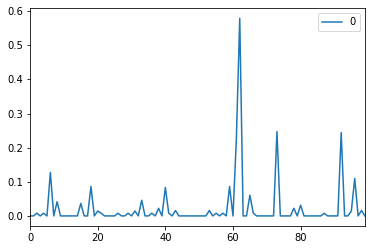

In [118]:
# Entropy
ID_ENTROPY = "runs/LeNet5/mnist_test_entropy.csv"
print("Entropy")
df_conf = pd.read_csv(ID_ENTROPY, index_col=0)
print("Min: ", df_conf.iloc[:,0].min())
print("Max: ", df_conf.iloc[:,0].max())
df_conf.plot()

In [119]:
# ECE
print("ECE")

import torch
import engine
from netcal.metrics import ECE

# load model
model = engine.models.lenet5.LeNet5()
state_dict_path = "./runs/LeNet5/LeNet5.pt"
model.load_state_dict(torch.load(state_dict_path, map_location=torch.device('cpu')))

### OOD ###
# init OOD dataloader
dataloader = engine.dataloader.ImageDataLoader(
    data_folder='./data/mnist',
    batch_size=1,
    shuffle=False,
    train_mode=False,
    max_items=-1
).dataloader

# test model
ground_truth = list()
confidence = list()
with torch.no_grad():
    for idx, (example, label) in enumerate(dataloader.dataset):
        # get model output    
        prediction = model(torch.unsqueeze(example,dim=0))        
        ground_truth.append(label)
        confidence.append(torch.nn.Softmax()(prediction).numpy())

ground_truth = np.array(ground_truth)
confidence = np.vstack(np.array(confidence))
#print(confidence[0])
#print(ground_truth.shape)

ECE
C:\Users\fvajana\Miniconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ECE:  0.0016607138901949424


Text(0, 0.5, 'Fraction of positive')

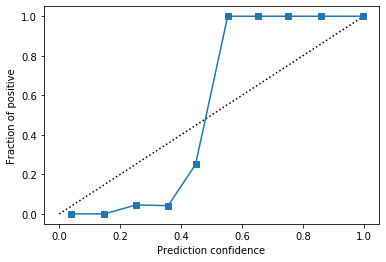

In [120]:
# compute ECE
n_bins = 10
ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidence, ground_truth)
print("ECE: ", uncalibrated_score)


from sklearn.calibration import calibration_curve

# get predicted class
p_classes = [np.argmax(p_arr) for p_arr in confidence]
# print(p_classes)

y_true = [1 if pred == ground_truth[idx] else 0 for idx, pred in enumerate(p_classes)]
# y_true[-1] = 0 # a fake wrong prediction to enable ECE calculation
y_prob = [confidence[idx][l] for idx, l in enumerate(ground_truth)]

# print(list(zip(p_classes, y_true, y_prob))[:5])


fraction_positive, mean_prediction_value = calibration_curve(y_true, y_prob, False, 10)
# print(fraction_positive, mean_prediction_value)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_prediction_value, fraction_positive, "s-")
plt.xlabel("Prediction confidence")
plt.ylabel("Fraction of positive")

## NOT-MNIST

In [121]:
OOD_NLL = "runs/LeNet5/no-mnist_test_nll.csv"
OOD_SOFTMAX = "runs/LeNet5/no-mnist_test_softmax_dist.csv"

# NLL
print("NLL")
df_nll = pd.read_csv(OOD_NLL, index_col=0)
print(df_nll.head())
print(df_nll.iloc[:10].std(axis=1))

print("\n\n")

# SOFTMAX
print("SOFTMAX")
df_soft = pd.read_csv(OOD_SOFTMAX, index_col=0)
print(df_soft.head())
print(df_soft.iloc[:10].std(axis=1))


NLL
      0   1     2   3     4   5   6   7   8   9
0 -0.00 inf   inf inf   inf inf inf inf inf inf
1   inf inf -0.00 inf   inf inf inf inf inf inf
2   inf inf -0.00 inf   inf inf inf inf inf inf
3   inf inf   inf inf -0.00 inf inf inf inf inf
4   inf inf   inf inf -0.00 inf inf inf inf inf
0   nan
1   nan
2   nan
3   nan
4   nan
5   nan
6   nan
7   nan
8   nan
9   nan
dtype: float64



SOFTMAX
     0    1    2    3    4    5    6    7    8    9
0 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
2 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
3 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00
4 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00
0   0.32
1   0.32
2   0.32
3   0.32
4   0.32
5   0.32
6   0.32
7   0.32
8   0.32
9   0.32
dtype: float64
